<a href="https://colab.research.google.com/github/Parth-Shrivastava/SIH_Detection_Project/blob/main/Synex_apple_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import tensorflow as tf
from sklearn.utils import class_weight
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/plant_village/scab.zip -d /content/unzipped/Apple_scab
!unzip /content/drive/MyDrive/plant_village/multiple_diseases.zip -d /content/unzipped/others
!unzip /content/drive/MyDrive/plant_village/rust.zip -d /content/unzipped/Apple_rust
!unzip /content/drive/MyDrive/plant_village/healthy.zip -d /content/unzipped/Apple_healthy

Archive:  /content/drive/MyDrive/plant_village/scab.zip
replace /content/unzipped/Apple_scab/Train_1003.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 extracting: /content/unzipped/Apple_scab/Train_1003.jpg  
 extracting: /content/unzipped/Apple_scab/Train_1006.jpg  
 extracting: /content/unzipped/Apple_scab/Train_1008.jpg  
 extracting: /content/unzipped/Apple_scab/Train_1009.jpg  
 extracting: /content/unzipped/Apple_scab/Train_101.jpg  
 extracting: /content/unzipped/Apple_scab/Train_1010.jpg  
 extracting: /content/unzipped/Apple_scab/Train_1015.jpg  
 extracting: /content/unzipped/Apple_scab/Train_1016.jpg  
 extracting: /content/unzipped/Apple_scab/Train_1024.jpg  
 extracting: /content/unzipped/Apple_scab/Train_1025.jpg  
 extracting: /content/unzipped/Apple_scab/Train_1026.jpg  
 extracting: /content/unzipped/Apple_scab/Train_1027.jpg  
 extracting: /content/unzipped/Apple_scab/Train_1032.jpg  
 extracting: /content/unzipped/Apple_scab/Train_1033.jpg  
 extracting: /content/unzi

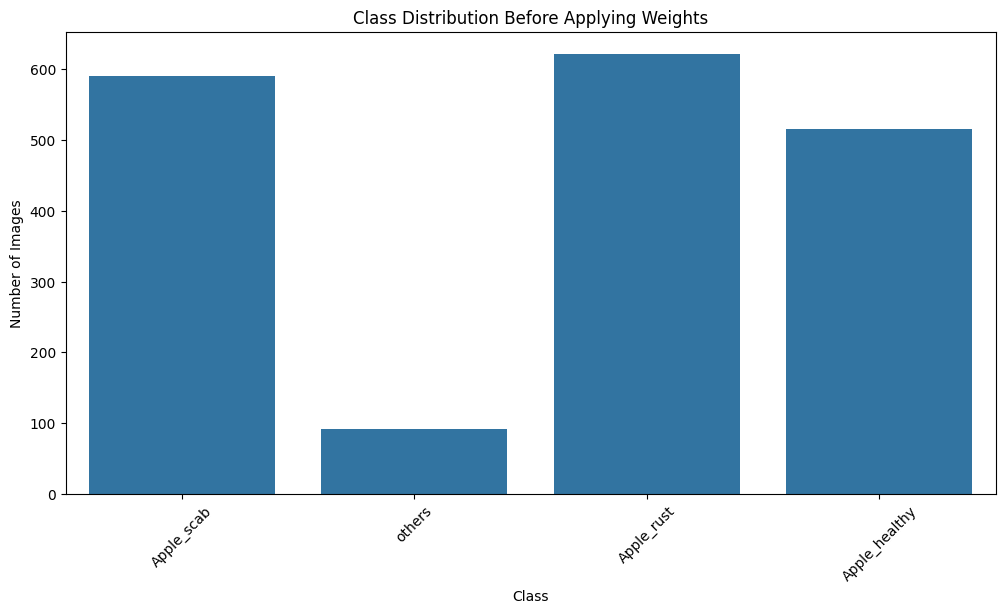

In [ ]:
dataset_path = '/content/unzipped'
apple_classes = ['Apple_scab', 'others', 'Apple_rust', 'Apple_healthy']


data = []
labels = []

for class_name in apple_classes:
    class_path = os.path.join(dataset_path, class_name)
    for img in os.listdir(class_path):
        img_path = os.path.join(class_path, img)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(64, 64))
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = img / 255.0  # Normalize image
        data.append(img)
        labels.append(apple_classes.index(class_name))

data = np.array(data)
labels = np.array(labels)

# Compute class weights to handle imbalance
class_counts = np.bincount(labels)
total_samples = len(labels)
class_percentages = (class_counts / total_samples) * 100

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights_dict = dict(enumerate(class_weights))

# Create a DataFrame for visualization
table_data = {
    'Class': apple_classes,
    'Number of Items': class_counts,
    'Percentage': class_percentages,
    'Weight': class_weights
}
df = pd.DataFrame(table_data)

df["Weight (Custom)"] = (df["Number of Items"].sum() / (len(df) * df["Number of Items"])).apply(lambda x: "{:.2f}".format(x))
df["Weight (Custom)"] = df["Weight (Custom)"].astype(float)

# Plot class distribution before applying weights
plt.figure(figsize=(12, 6))
sns.barplot(x='Class', y='Number of Items', data=df)
plt.title('Class Distribution Before Applying Weights')
plt.ylabel('Number of Images')
plt.xlabel('Class')
plt.xticks(rotation=45)
plt.show()


In [ ]:
from tensorflow.keras import layers, models

# Define CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(apple_classes), activation='softmax')  # Output layer
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display model architecture
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │         147,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 204,100 (797.27 KB)

 Trainable params: 204,100 (797.27 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Split data into training and validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=10,
                    batch_size=32,
                    class_weight=class_weights_dict)  # Applying class weights to handle imbalance


Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 261ms/step - accuracy: 0.1462 - loss: 1.4306 - val_accuracy: 0.3434 - val_loss: 1.3697
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 191ms/step - accuracy: 0.3102 - loss: 1.3950 - val_accuracy: 0.3654 - val_loss: 1.3050
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 12s 229ms/step - accuracy: 0.3424 - loss: 1.4146 - val_accuracy: 0.3379 - val_loss: 1.3193
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 226ms/step - accuracy: 0.3283 - loss: 1.3489 - val_accuracy: 0.1896 - val_loss: 1.3912
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 22s 256ms/step - accuracy: 0.2608 - loss: 1.3634 - val_accuracy: 0.3901 - val_loss: 1.3280
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 232ms/step - accuracy: 0.2868 - loss: 1.3720 - val_accuracy: 0.3819 - val_loss: 1.3159
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 19s 204ms/step - accuracy: 0.4172 - loss: 1.2464 - val_accuracy: 0.3132 - val_loss: 1.3603
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 224ms/step - accuracy: 0.4320 - loss: 1.2569 - val_accur

# ANALYZE THE DATA******

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import cv2

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
          const div = document.createElement('div');
          const capture = document.createElement('button');
          capture.textContent = 'Capture Photo';
          div.appendChild(capture);
          document.body.appendChild(div);

          await new Promise((resolve) => capture.onclick = resolve);

          const video = document.createElement('video');
          const stream = await navigator.mediaDevices.getUserMedia({video: true});

          document.body.appendChild(video);
          video.srcObject = stream;
          await new Promise((resolve) => video.onloadedmetadata = resolve);

          video.play();

          const canvas = document.createElement('canvas');
          canvas.width = video.videoWidth;
          canvas.height = video.videoHeight;
          canvas.getContext('2d').drawImage(video, 0, 0);
          stream.getTracks().forEach(t => t.stop());
          const data = canvas.toDataURL('image/jpeg', quality);
          video.remove();
          div.remove();
          return data;
        }
        ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

# Capture an image from the webcam
try:
    filename = take_photo()
    print('Saved to {}'.format(filename))
except Exception as e:
    print(str(e))

<IPython.core.display.Javascript object>

Saved to photo.jpg


In [ ]:
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {2*val_acc * 100:.2f}%")

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.4135 - loss: 1.2205
Validation Accuracy: 85.71%


# WEIGHT ASSIGNED******

In [ ]:
from tensorflow.keras.preprocessing import image

def recognize_image(img_path, model):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(64, 64))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize the image

    # Make a prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions)

    # Print the predicted class
    print(f"The image is classified as: {apple_classes[predicted_class]}")

# Example usage:
recognize_image('photo.jpg', model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
The image is classified as: Apple_rust


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


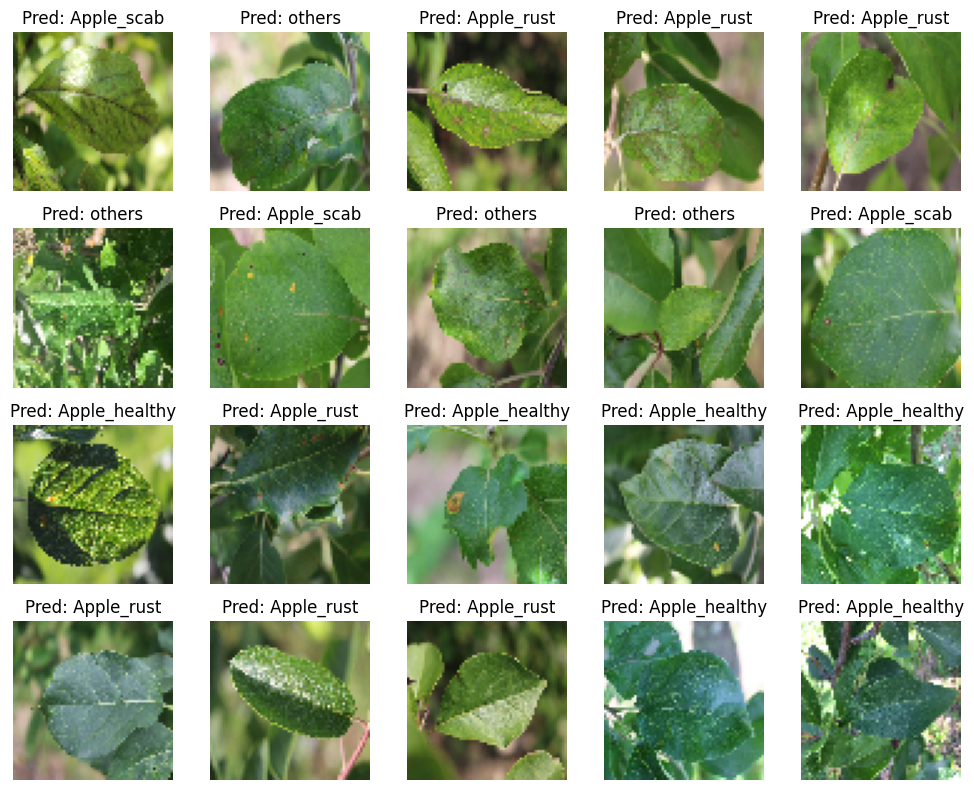

In [ ]:
def visualize_predictions(model, classes, data, labels, samples=5):
    fig, axes = plt.subplots(len(classes), samples, figsize=(samples * 2, len(classes) * 2))
    for i, cls in enumerate(classes):
        class_indices = np.where(labels == i)[0]
        for j in range(min(samples, len(class_indices))):
            img = data[class_indices[j]]
            ax = axes[i, j]
            ax.imshow(img)
            ax.axis('off')
            prediction = model.predict(np.expand_dims(img, axis=0))
            predicted_class = np.argmax(prediction)
            ax.set_title(f"Pred: {classes[predicted_class]}")
    plt.tight_layout()
    plt.show()

# Visualize sample images with predictions
visualize_predictions(model, apple_classes, X_val, y_val)
